# 05 - Taming Text

In [3]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords, opinion_lexicon
from nltk.sentiment import *
from scipy.misc import imread
from collections import Counter
from gensim import models, corpora, similarities
import pandas as pd
import numpy as np
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import networkx as nx
import community
import string
from pylab import Rectangle
%matplotlib inline

In [4]:
# import data
directory = 'hillary-clinton-emails/'
aliases = pd.read_csv(directory+'aliases.csv')
email_receivers = pd.read_csv(directory+'EmailReceivers.csv')
emails = pd.read_csv(directory+'Emails.csv')
persons = pd.read_csv(directory+'Persons.csv')

### Comparison between extracted body text and raw text

In [5]:
i = 2
print(emails['ExtractedBodyText'][i], '\n\n END OF BODY TEXT \n\n', emails['RawText'][i])


Thx 

 END OF BODY TEXT 

 UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739547
Date: 05/14/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From: Mills, Cheryl D <MillsCD@state.gov>
Sent: Wednesday, September 12, 2012 11:52 AM
To: B6
Cc: Abedin, Huma
Subject: Re: Chris Stevens
Thx
Original Message
From: Anne-Marie Slaughter [
Sent: Wednesday, September 12, 2012 07:46 AM
To: Ihdr22@clintonernail.com' <hdr22@clintonemail corn>
Cc: Abed in, Huma; Mills, Cheryl D
Subject: Chris Stevens
To you and all my former colleagues, I'm so terribly sorry. Our FSOs stand on the front lines just as surely and devotedly
as our soldiers do. Thinking of you and Pat and everyone this morning.
AM
UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739547
Date: 05/14/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE IN

By reading a few emails we can see that the extracted body text is just the text that the email sender wrote (as stated on Kaggle) while the raw text gathers the previous emails forwarded or the whole discussion. Note that the extracted body text can sometimes contain NaNs. By including repeated messages in the raw text, you induce bias in the distribution of the words, thus we kept only the body text

## 1. Worldclouds

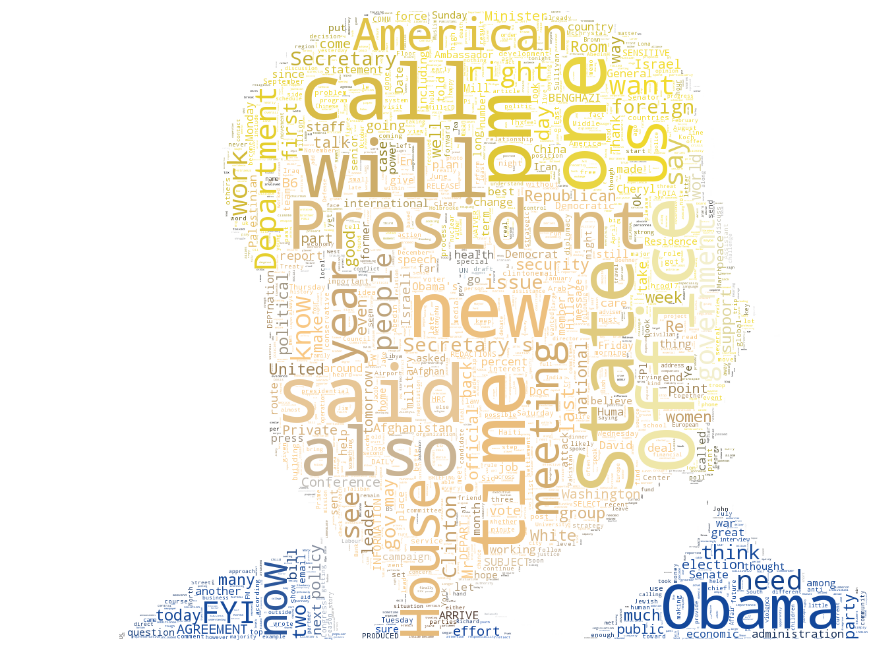

In [25]:
# raw corpus
text_corpus = emails.ExtractedBodyText.dropna().values
raw_text = ' '.join(text_corpus)

# generate wordcloud
mask = imread('masks/potus.png')
wordcloud = WordCloud(background_color='white', width=2000, height=2000, prefer_horizontal=0.6, mask=mask, min_font_size=3,
                      max_font_size=120, 
                       max_words=2000).generate(raw_text)
plt.figure(figsize=(15,15))
image_colors = ImageColorGenerator(mask)
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis('off');
plt.savefig('figures/Raw_WordCloud.png')

In [7]:
def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % np.random.randint(50, 100)

In [8]:
def preprocess(text, stemmer):
    print('Length of raw text: ', len(raw_text))
    
    # tokenization 
    tokens = nltk.word_tokenize(raw_text, language='english')
    print('Number of tokens extracted: ', len(tokens))
    
    # stopwords removal 
    # cach stopwords to improve performance (70x speedup)
    cached_stopwords = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in cached_stopwords]
    print('Number of tokens after stopword removal: ', len(filtered_tokens))
    
    # stemming
    if stemmer == 'snowball':
        stemmer = nltk.SnowballStemmer('english')
    elif stemmer == 'porter':
        stemmer = nltk.PorterStemmer('english')
    else: 
        print('choose appropriate stemmer')
    stemmed_filtered_tokens = [stemmer.stem(t) for t in filtered_tokens]
    
    output = ' '.join(stemmed_filtered_tokens)
    return output
        

In [9]:
preprocessed_text = preprocess(raw_text, 'snowball')

Length of raw text:  3601322
Number of tokens extracted:  697009
Number of tokens after stopword removal:  475544


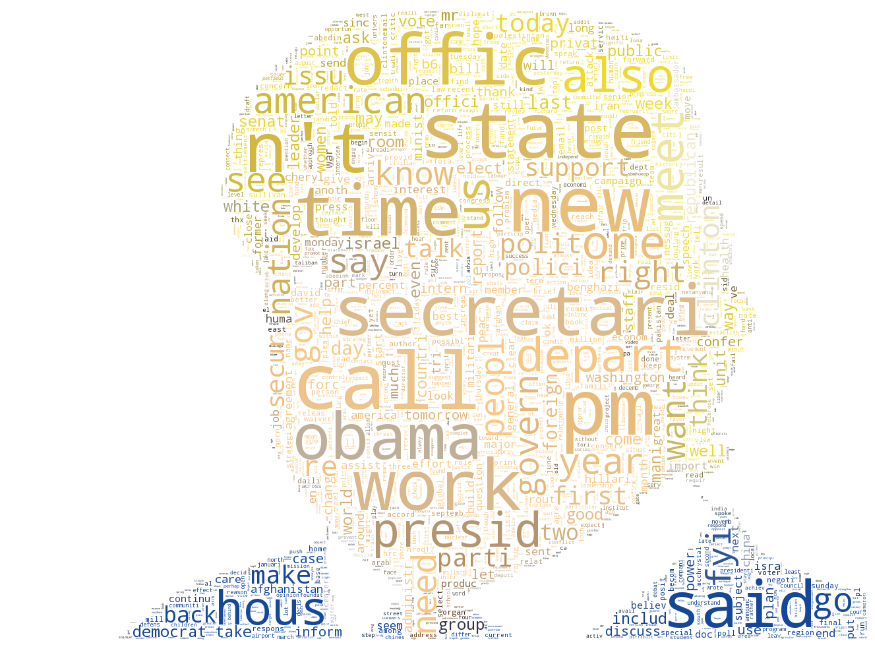

In [24]:
# word cloud with preprocessing
mask = imread('masks/potus.png')
wordcloud2 = WordCloud(background_color='white', width=2000, height=2000, prefer_horizontal=0.6, mask=mask, min_font_size=3,
                      max_font_size=120, 
                       max_words=2000).generate(preprocessed_text)
plt.figure(figsize=(15,15))
image_colors = ImageColorGenerator(mask)
plt.imshow(wordcloud2.recolor(color_func=image_colors))
plt.axis('off');
plt.savefig('figures/Preprocessed_WordCloud.png')

## Comparison between the word clouds

Looking at the wordcloud generated after having preprocessed the data, it seems that stemming hurt the "performance" of the wordcloud, indeed a number of words have been incorrectly stemmed e.g. department has been reduced to depart, secretary to secretary, message to messag and so on. Also the distribution of the words are not the same, obviously.

# 2. Sentiment analysis
from [this link](https://www.kaggle.com/ampaho/d/kaggle/hillary-clinton-emails/foreign-policy-map-through-hrc-s-emails/code),we added the following words to be removed from the emails:
* add "RE" because the iso3 code for Reunion islands.. but it appears a lot in emails to indicate the RE(sponses) to previous emails.
* FM
* TV is ISO2 code for Tuvalu but also refers to Television
* AL is a given name and also ISO2 for Albania
* BEN is a given name and also ISO3 for Benin
* LA is Los angeles and iso 2 for Lao
* AQ is abbreviation of "As Quoted" and iso 2 for Antarctica

After a few runs, we looked at the (unusual) countries extracted. For example the country Saint Pierre and Miquelon is mentionned 631 times, not bad for such a small country. We noticed that an important number of emails have words capitalized and are misinterpreted as ISO2/ISO3 codes for countries. To cope with this we added the following stop words:
* AND is ISO3 for Andorra
* AM is ISO2 for Armenia
* AT is ISO2 for Austria
* IN is ISO2 for India
* NO is ISO2 for Norway
* PM is iSO2 for Saint Pierre and Miquelon
* TO is ISO2 for Tonga
* BY is ISO2 for Belarus
* IE is ISO2 for Ireland (id est)
* IT is ISO2 for Italy
* MS is ISO2 for Montserrat

In [11]:
# extract country names / ISO2 codes / ISO3 codes from pycountry
country_objects = list(pycountry.countries)
country_names = []
country_ISO2s = []
country_ISO3s = []
for country in country_objects:
    country_names.append(country.name)
    country_ISO2s.append(country.alpha_2)
    country_ISO3s.append(country.alpha_3)

In [12]:
# find mentionned countries in a list of tokens
def find_countries(tokens, country_names=country_names, country_ISO2s=country_ISO2s, country_ISO3s=country_ISO3s):
    upper_tokens = ' '.join(tokens).title().split()
    countries_by_name = set.intersection(set(upper_tokens), set(country_names))
    countries_by_ISO2 = set.intersection(set(tokens), set(country_ISO2s))
    countries_by_ISO3 = set.intersection(set(tokens), set(country_ISO3s))
    for ISO2 in countries_by_ISO2:
        countries_by_name.add(pycountry.countries.get(alpha_2=ISO2).name)
    for ISO3 in countries_by_ISO3:
        countries_by_name.add(pycountry.countries.get(alpha_3=ISO3).name)
    return countries_by_name

In [13]:
# find countries + sentiment analysis for each email
def foreign_policy(emails, sentiment_analyzer):
    start_time = time.time()
    words_to_be_removed = ["RE", "FM", "TV", "LA", "AL", "BEN", "AQ", "AND", "AM", "AT", "IN", "NO", "PM", "TO",
                          "BY", "IE", "IT", "MS"]
    vader_analyzer = SentimentIntensityAnalyzer()
    foreign_policy = {}
    cached_stopwords = set(stopwords.words('english'))
    cached_stopwords.update(words_to_be_removed)
    i=0
    score = 0
    for email in emails:
        # tokenization and stopwords removal
        tokens = nltk.word_tokenize(email, language='english')
        tokens = [word for word in tokens if word not in cached_stopwords]
        # country lookup in tokens
        countries = find_countries(set(tokens))
        i +=1
        if not countries: continue
        # sentiment analysis
        if sentiment_analyzer =='vader':
            sentiment = vader_analyzer.polarity_scores(email)
            score = sentiment['compound']
        elif sentiment_analyzer =='liu_hu':
                    score = score + len(set.intersection(set(tokens), set(opinion_lexicon.positive()))) \
                                        - len(set.intersection(set(tokens), set(opinion_lexicon.negative())))
        else: print("Choose vader or liu_hu as analyzer")
        # add country + score to dictionnary
        for country in countries:
            if not country in foreign_policy.keys():
                foreign_policy.update({country: [score, 1]})
            else:
                foreign_policy[country][0] += score
                foreign_policy[country][1] += 1
    # compute mean score for each country
    for country, value in foreign_policy.items():
        foreign_policy.update({country: [(value[0]/value[1]), value[1]]})
    print("--- %d seconds elapsed ---" % (time.time() - start_time))
    return foreign_policy

In [12]:
result = foreign_policy(text_corpus, sentiment_analyzer='vader')

--- 821 seconds elapsed ---


In [14]:
# create color palette from array of values
def create_palette(sentiments):
    color_palette = []
    minimum = np.min(sentiments)
    maximum = np.max(sentiments)
    for sentiment in sentiments:
        rescaled = (sentiment-minimum) / (maximum - minimum)
        g = rescaled
        r = 1 - g
        color_palette.append((r,g,0))
    return color_palette

### Plotting the foreign policy

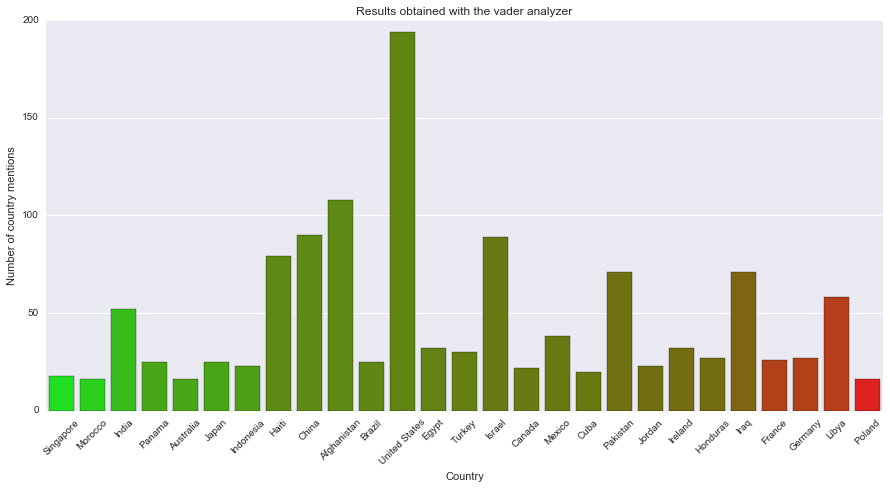

In [14]:
# put the dictionnary into a dataframe and postprocess data for plotting
df = pd.DataFrame.from_dict(result, orient='index')
df.reset_index(inplace=True)
df.columns =['Country', 'Sentiment', 'Count']
df = df[df['Count'] > 15]
df = df.sort_values('Sentiment', ascending=False)
gradient = create_palette(df['Sentiment'].values)
plt.figure(figsize=(15,7))
plot = sns.barplot(x='Country', y='Count', data=df, orient='vertical', palette=gradient)
plt.xticks(rotation=45);
plt.ylabel('Number of country mentions')
plt.title('Results obtained with the vader analyzer');

On the above plot we see each country that appears more than 15 times, ordered and colored by sentiment

In [15]:
result2 = foreign_policy(text_corpus, sentiment_analyzer='liu_hu')

--- 37 seconds elapsed ---


### Plot using Liu Hu lexicon sentiment analysis

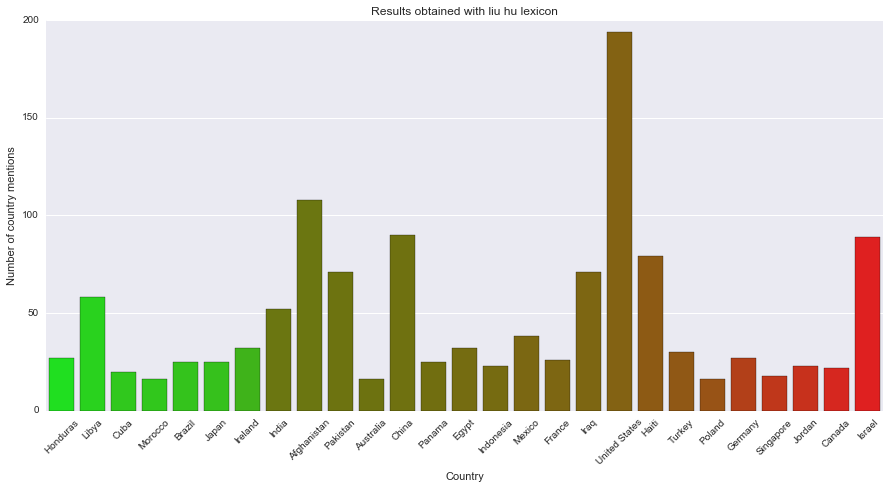

In [16]:
df = pd.DataFrame.from_dict(result2, orient='index')
df.reset_index(inplace=True)
df.columns =['Country', 'Sentiment', 'Count']
df = df[df['Count'] > 15]
df = df.sort_values('Sentiment', ascending=False)
gradient = create_palette(df['Sentiment'].values)
plt.figure(figsize=(15,7))
plot = sns.barplot(x='Country', y='Count', data=df, orient='vertical', palette=gradient)
plt.xticks(rotation=45);
plt.ylabel('Number of country mentions')
plt.title('Results obtained with liu hu lexicon');

### Some observations:
There is a lot of difference between the vader analyzer and the Liu Hu method, for example Singapore is the most positive country with vader while it is one of the "worst" countries with the Liu Hu method. This can be explained by the fact that we didn't take into account any neutral word when we computed the score with the Liu hu method, the "compound" metric returned by vader is already normalized with respect to the number of words and their respective sentiment in the email to be analyzed.

# 3. Topic modeling

In [17]:
texts = []
for mail in emails.ExtractedBodyText.dropna():
    mail = mail.translate(string.punctuation)
    tokens = nltk.word_tokenize(mail, language='english')
    words_to_be_removed = {".", ",", "\s", "(", ")", "\'s", ":", "?", "\'\'", "!", "-", "--", ";", "#", "]", "[", "@",
                          "<", ">", "``", "...","n't","'m"}
    
    cached_stopwords = set(stopwords.words('english'))
    cached_stopwords.update(words_to_be_removed)
    
    filtered_tokens = [word for word in tokens if word.lower() not in cached_stopwords and len(word) > 1]

    texts.append(filtered_tokens)
    
Dict = corpora.Dictionary(texts)
corp = [Dict.doc2bow(text) for text in texts]

In [18]:
# As explained below, 14 topics chosen.
lda = models.ldamodel.LdaModel(corp, num_topics=14, id2word = Dict)

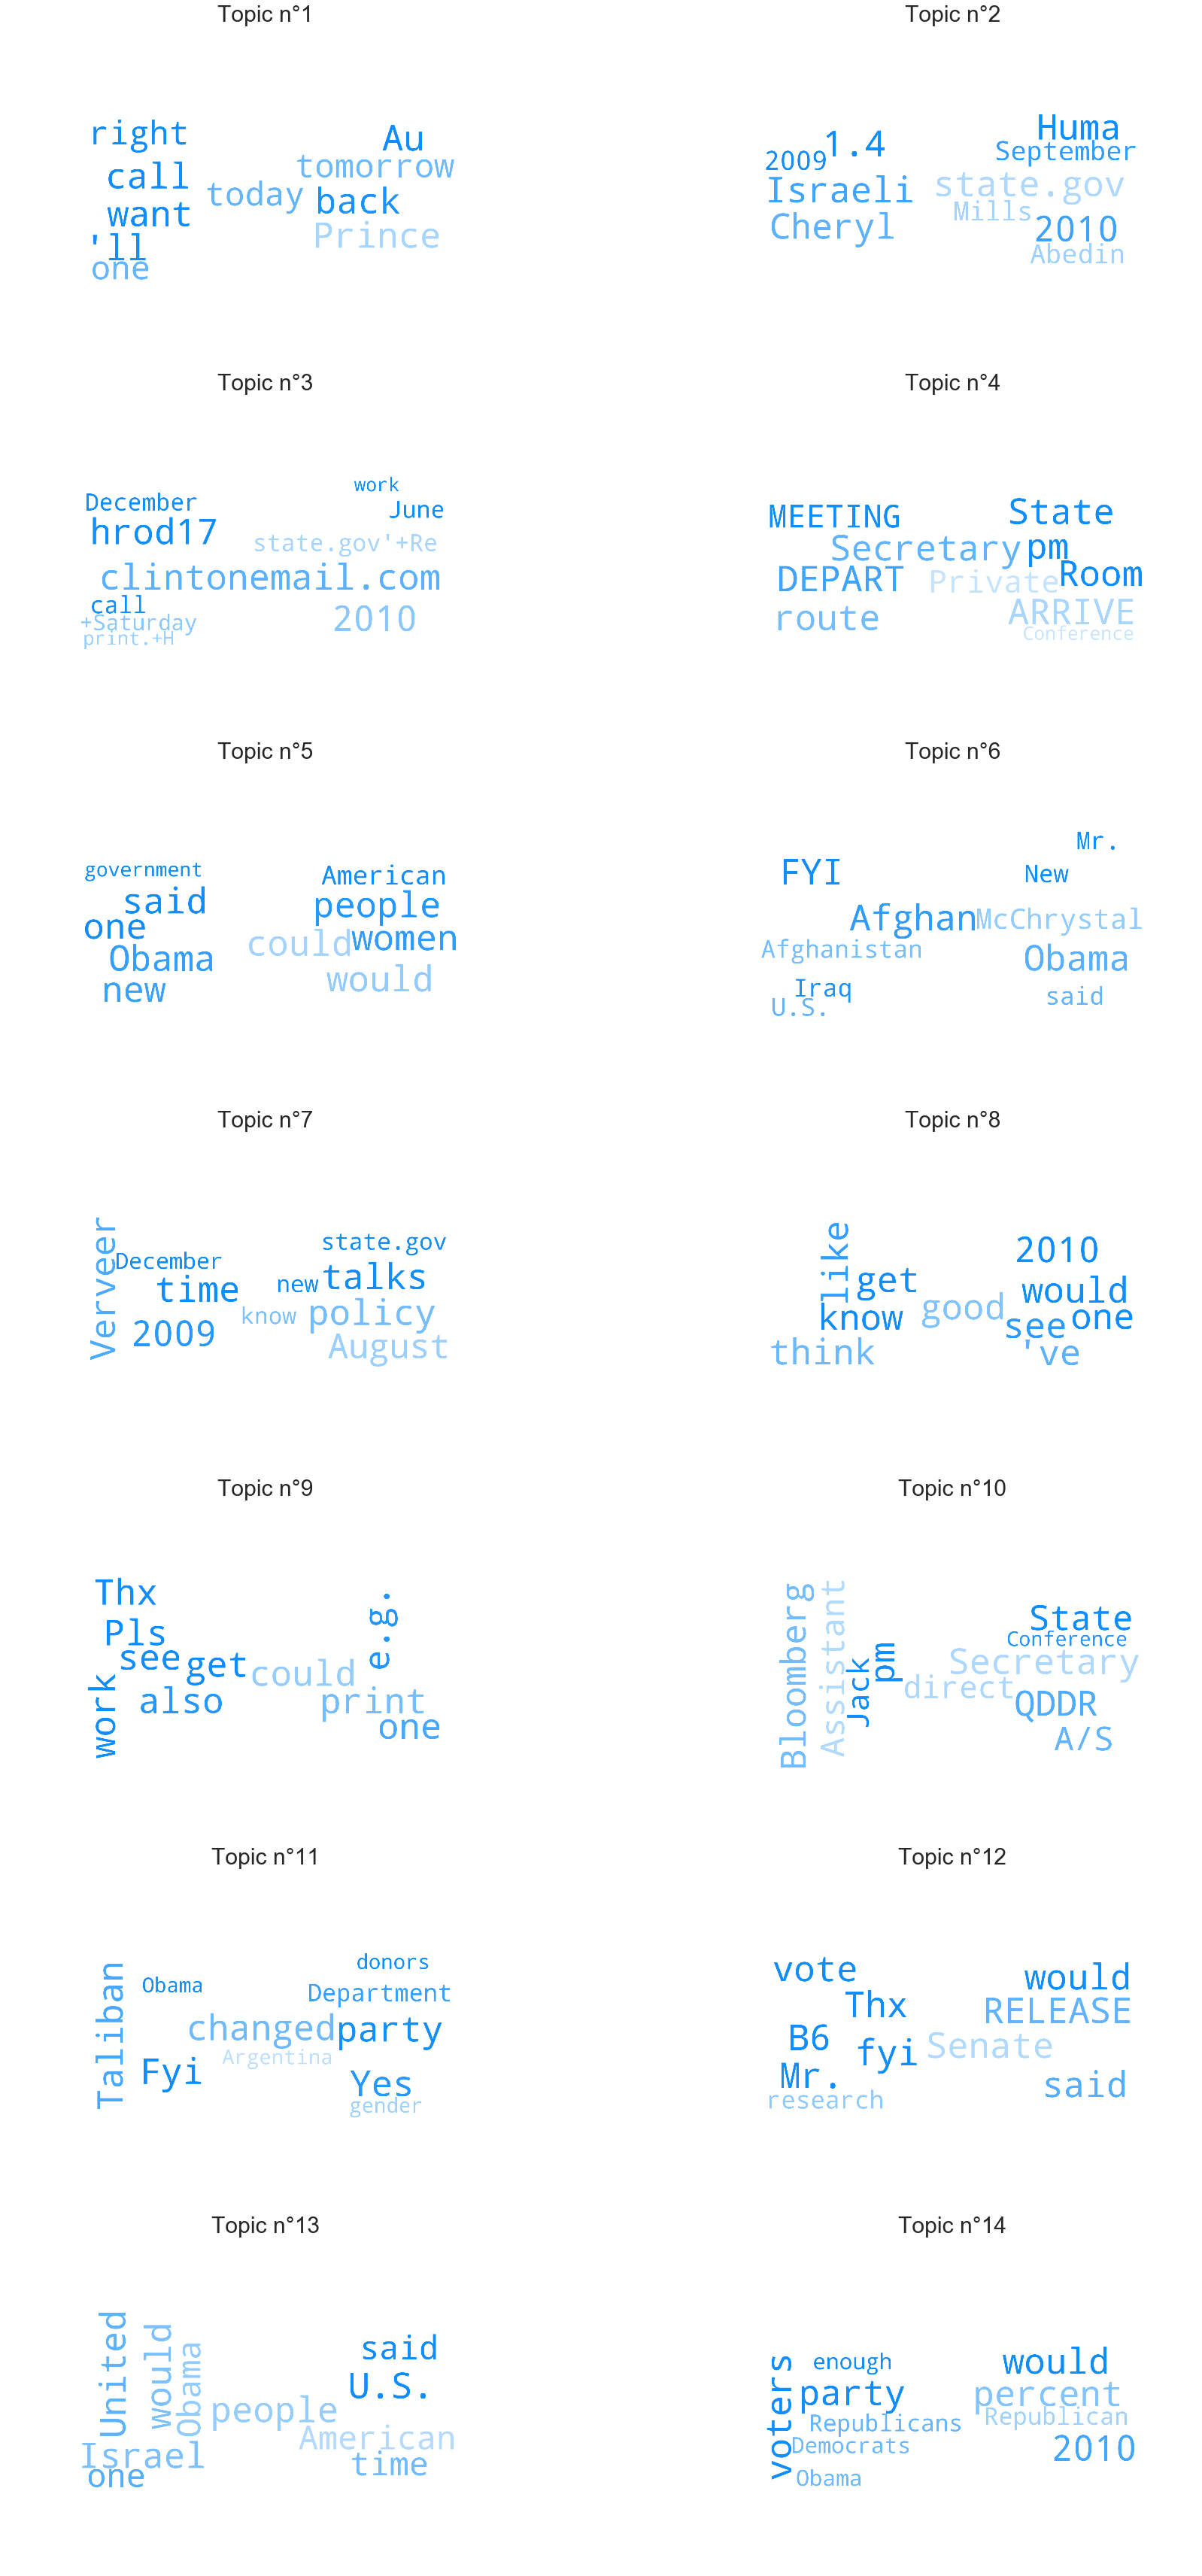

In [19]:
data = lda.show_topics(14)
f, axarr = plt.subplots(7, 2, figsize=(30,60))
k = 0

# We create a WordCloud for each topic.
for a in data :
    blocks = a[1].split(' + ')
    res = [x.split('*') for x in blocks]
    words = [x[1][1:-1] for x in res]
    scores = [float(x[0]) for x in res]
    dict_words = []
    for (word, score) in zip(words, scores) :
        dict_words.append((word, score))
    
    mask_bow = imread('masks/bow.png')
    wordcloud = WordCloud(background_color='white', width=600, height=375,
                          mask=mask_bow, min_font_size=3,
                          max_font_size=150, max_words=2000).fit_words(dict_words)
    image_colors_bow = ImageColorGenerator(mask_bow)
    axarr[int((k-(k%2))/2), (k%2)].imshow(wordcloud.recolor(color_func=image_colors_bow))
    axarr[int((k-(k%2))/2), (k%2)].axis('off')
    axarr[int((k-(k%2))/2), (k%2)].set_title('Topic n°{}'.format(k+1), fontsize=30, y= 1.05)
    
    k += 1

plt.savefig('figures/Topic_Modelling_WordCloud.png')    

## Observations:
After running a few tests with different number of topics, it appears that if we go above 15 topics, we have ones which are not very intelligible. We decided to settle for 14 topics and showed them in the form of wordclouds in order to be able to do some comparisons with the results of the bonus question. The topics are:
### Topic n°1 : (Obama/ politics)
 percent > Obama > 2010 > said > like > would > one > Charles > Republican > Republicans 

### Topic n°2 : (please do this / please do that)
 Pls > print > call > add > 2010 > list > PIs > 10 > next > sure 

### Topic n°3 : (Israel / Palestine conflict)
 Israel > Richards > Israeli > call > settlements > Bibi > would > settlement > Netanyahu > make 

### Topic n°4 :
 Ok > PIH > B6 > Policy > Thx > Department > via > one > Blackberry > prevention 

### Topic n°5 :
 Prince > pm > Senate > Office > Sounds > Secretary > good > State > Ok. > Greek 

### Topic n°6 :
 1.4 > 2010 > Declassify > Verveer > +1.4 > message > Melanne > donors > Reason > 14 

### Topic n°7 :
 Obama > would > said > one > government > new > know > people > U.S. > American 

### Topic n°8 :
 would > said > people > could > Mr. > also > time > American > Obama > women 

### Topic n°9 :
 would > Fyi > FYI > one > see > work > get > U.S. > like > time 

### Topic n°10 : (meeting scheduling)
 pm > Secretary > ARRIVE > Room > route > State > DEPART > MEETING > Private > Conference 

### Topic n°11 :
 would > think > talk > like > today > work > Thanks > said > time > Thx 

### Topic n°12 :
 2010 > Secretary > State > Palestinians > Beck > one > United > 2009 > State+ > see 

### Topic n°13 :
 call > 2010 > state.gov > Cheryl > clintonemail.com > Bloomberg > hrod17 > get > Huma > Mills 

### Topic n°14 :
 2010 > state.gov > hrod17 > clintonemail.com > Press > Clips > Strategic > Dialogue > email > note

# Bonus Question

In [20]:
# build the communication graph of emails: nodes are email senders/receivers, edges are emails between them

sender = emails[['Id', 'SenderPersonId']]
receiver = email_receivers[['EmailId', 'PersonId']]
receiver.columns = ['Id', 'PersonId']

receiver.set_index('Id')
sender.set_index('Id')

mail = pd.merge(receiver, sender)
mail = mail.dropna()

G = nx.from_pandas_dataframe(mail, 'SenderPersonId', 'PersonId')
partition = community.best_partition(G)

In [21]:
# find communities
communities = set(partition.values())
authors = {}
deg = nx.degree(G)

for comm in communities :
    authors[comm] = [personID for personID, current_comm in partition.items() if current_comm == comm]

In [22]:
# preprocessing with custom stop words, without stemming
def preprocess_basic(text):
    
    tokens = nltk.word_tokenize(raw_text, language='english')
    
    words_to_be_removed = {".", ",", "\s", "(", ")", "\'s", ":", "?", "\'\'", "!", "-", "--", ";", "#", "]", "[", "@",
                          "<", ">", "``", "...", "%", "—", "n't"}
    cached_stopwords = set(stopwords.words('english'))
    cached_stopwords.update(words_to_be_removed)
    filtered_tokens = [word for word in tokens if word.lower() not in cached_stopwords and len(word) > 1]
    

    return filtered_tokens

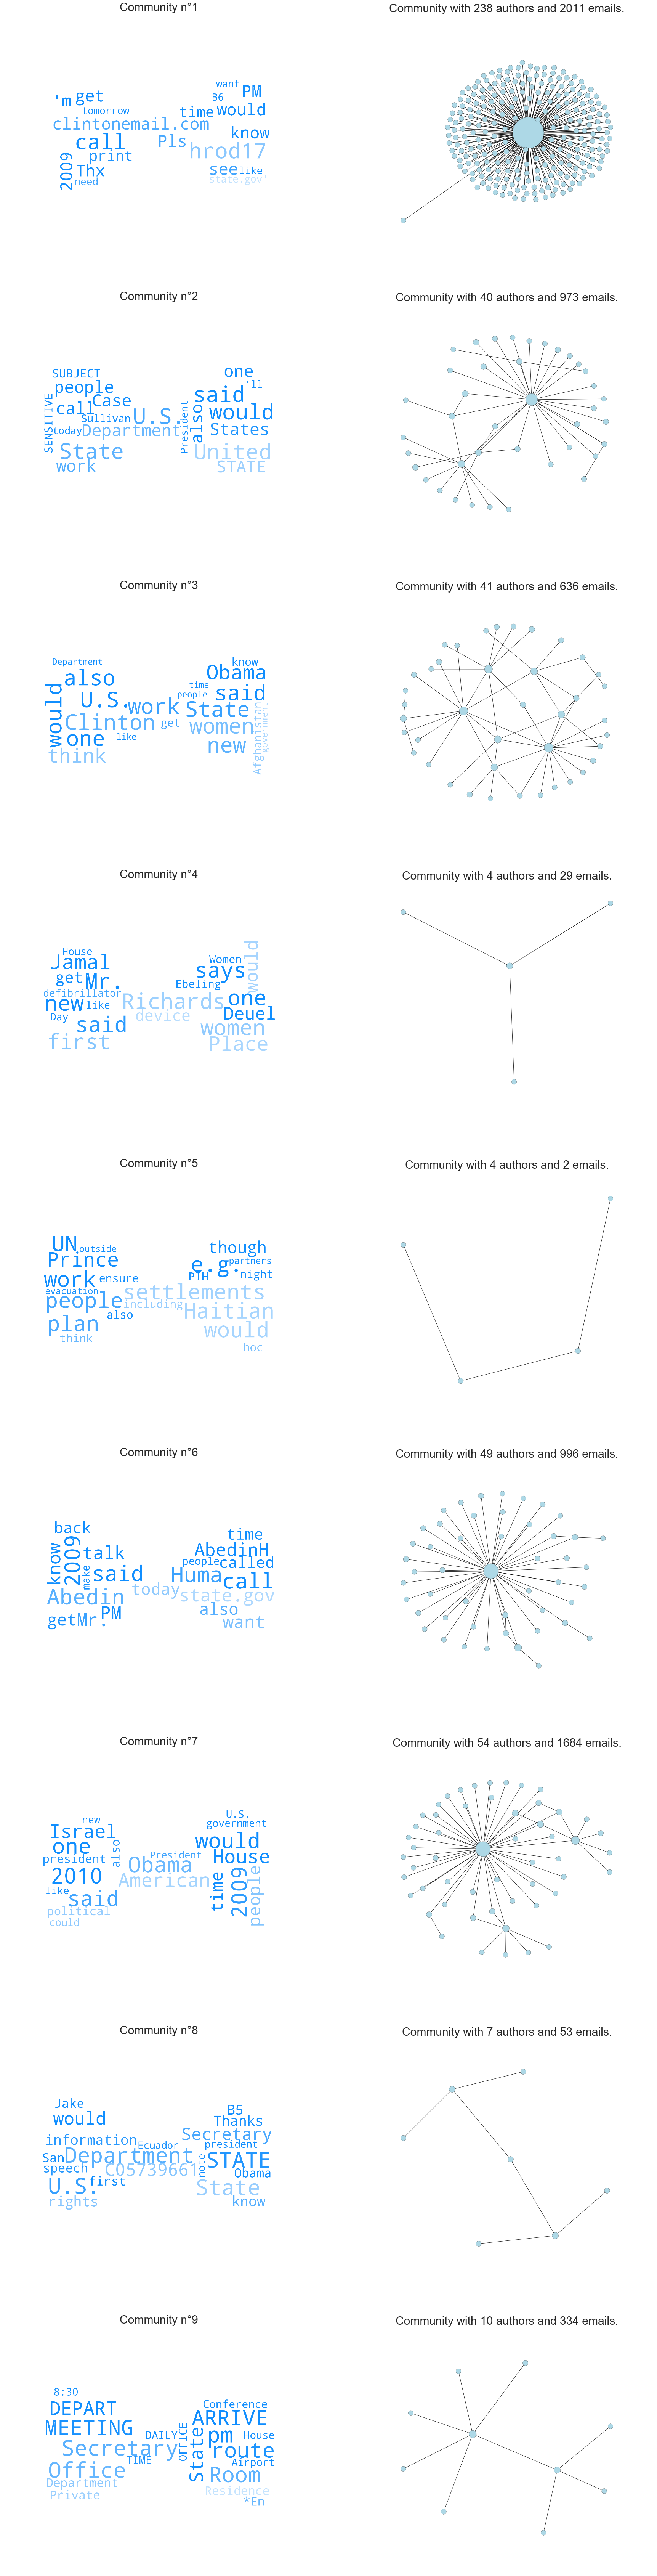

In [23]:
# cell for plotting the results
f, axarr = plt.subplots(9, 2, figsize=(30,120))
k = 0
for i in range(0,len(authors)) :
    
    # We filter emails, using only ones from authors in the given community. We don't do stemming on them,
    # only basic tokenisation.
    emails_filtered = emails[(emails.SenderPersonId.isin(authors[i]))]
    text_corpus = emails_filtered.ExtractedBodyText.dropna().values
    raw_text = ' '.join(text_corpus)
    clean_texts = preprocess_basic(raw_text)
    word_count = dict(Counter(clean_texts))
    
    # We reverse the dictionnary, in order to get only the 20 most frequent words.
    inv_word_count = {}
    for word, number in word_count.items():
        inv_word_count[number] = inv_word_count.get(number, [])
        inv_word_count[number].append(word)
    selected_keys = sorted(inv_word_count.keys(), reverse=True)[:20]
    dict_you_want = { x: inv_word_count[x][0] for x in selected_keys }
    
    dict_words = []
    for word, score in zip(dict_you_want.values(), dict_you_want.keys()):
        dict_words.append((word, score))
        
    # We only plot communities with more than one email, to have usable results (see results below).
    if len(text_corpus) > 1  :
        
        #elements = WordCloud(width=600, height=375).fit_words(dict_words)
        
        
        mask_bow = imread('masks/bow.png')
        wordcloud = WordCloud(background_color='white', width=600, height=375,
                              mask=mask_bow, min_font_size=3,
                              max_font_size=150, max_words=2000).fit_words(dict_words)
        image_colors_bow = ImageColorGenerator(mask_bow)
        axarr[k, 0].imshow(wordcloud.recolor(color_func=image_colors_bow))

        axarr[k, 0].axis('off')
        T = G.subgraph(authors[i])
        deg_comm = {x: deg[x] for x in authors[i]}
        node_size = [(s + 8) * 20 for s in deg_comm.values()]
        nx.draw(T,pos=nx.fruchterman_reingold_layout(T), node_size=node_size, node_color='lightblue', width=0.8, ax=axarr[k, 1])
        axarr[k, 0].set_title('Community n°{}'.format(k+1),
                             fontsize=30, y=1.15)
        axarr[k, 1].set_title('Community with {} authors and {} emails.'.format(len(authors[i]),len(text_corpus)),
                             fontsize=30)
        k += 1
        
plt.savefig('figures/Communities_WordCloud.png')

## Results:
We originally found 16 communities, 5 of which were empty and 2 others had only one email, thus we got rid of them. Communities with its 20 most fequents words are displayed below:
 ### Community n°1 : 
 call > hrod17 > clintonemail.com > Pls > Thx > would > know > 'm > get > see > PM > 2009 > print > 2010 > state.gov' > like > B6 > tomorrow > want > need 

### Community n°2 :
 U.S. > State > would > said > United > Department > people > States > work > call > also > one > STATE > 2010 > SUBJECT > REDACTIONS > Sullivan > President > today > 'll 

### Community n°3 :
 women > said > would > U.S. > Clinton > State > also > one > new > work > 2010 > think > Afghanistan > know > get > government > people > time > like > Department 

### Community n°4 :
 said > Mr. > Richards > says > women > new > one > FISA > Jamal > director > many > would > kids > 2010 > staff > Fox > ago > like > much > Amendment 

### Community n°5 :
 UN > settlements > people > Haitian > work > e.g. > could > would > committee > least > settlement > ensure > also > help > i.e. > largely > see > partners > support > delivery 

### Community n°6 :
 call > Huma > Abedin > 2009 > said > state.gov > AbedinH > want > Mr. > tomorrow > talk > know > today > get > also > called > 2010 > Secretary > people > make 

### Community n°7 :
 Obama > would > said > one > 2009 > 2010 > American > House > Israel > people > time > political > also > president > government > like > new > U.S. > could > President 

### Community n°8 :
 State > Department > U.S. > SUBJECT > Case > would > Secretary > information > B5 > rights > Thanks > know > speech > first > Jake > support > countries > see > Thnx > party 

### Community n°9 :
 pm > Secretary > Office > Room > MEETING > ARRIVE > route > DEPART > State > Department > Residence > Private > *En > Conference > TIME > DAILY > OFFICE > Airport > House > 8:45
 
 
 We observed the following: if the community is composed of a large set of emails, we find similarities with topics extracted using topic modeling. For small communities, since there is a small number of emails, the subject of the emails are more related and therefore the most frequent words are more coherent between each other.
 
 Among the communities, we found the following discussion topics:
 * community 5 seems to be about the Haitian earthquake (a bit of extrapolated)
 * community 9 is about scheduling and meeting/trips organization